# Machine Learning Model 이용

이 노트북에서는 실행 중인 서버와 상호 작용하기 위해 Python의 `requests` 라이브러리를 사용하는 최소 클라이언트를 코딩합니다.

In [5]:
import os
import io
import cv2
import requests
import numpy as np
from IPython.display import Image, display

## URL 이해

1. 서버는 URL [http://localhost:8000/](http://localhost:8000/) 에서 호스팅됩니다.
2. 모델을 제공하는 엔드포인트는 `/predict` 엔드포인트입니다.

`yolov3` 또는 `yolov3-tiny` 모델을 지정할 수 있습니다. 계산 효율성을 위해 작은 버전을 사용합니다.

In [6]:
base_url = 'http://localhost:8000'
endpoint = '/predict'
model = 'yolov4-tiny'

모델을 사용하려면 기본 URL에 엔드포인트를 추가하여 전체 URL을 가져옵니다. "?" 문자 다음에 매개변수의 이름과 값이 옵니다.

In [10]:
url_with_endpoint_no_params = base_url + endpoint
full_url = url_with_endpoint_no_params + "?model=" + model
full_url

'http://localhost:8000/predict?model=yolov4-tiny'

이 endpoint에는 모델 이름과 이미지가 모두 필요합니다. 그러나 이미지는 복잡하기 때문에 URL 내에서 전달되지 않고 `requests` 라이브러리를 활용하여 처리 합니다.

# 서버에 요청 보내기

### response_from_server 함수 코딩

request와 함께 파일을 전달하려면 파일 이름(이 경우 'file')과 실제 파일을 나타내는 dictionary를 생성해야 합니다.

 `status code 200`은 모든 것이 잘 진행되었음을 의미합니다.

In [11]:
def response_from_server(url, image_file, verbose=True):
    """Makes a POST request to the server and returns the response.

    Args:
        url (str): URL that the request is sent to.
        image_file (_io.BufferedReader): File to upload, should be an image.
        verbose (bool): True if the status of the response should be printed. False otherwise.

    Returns:
        requests.models.Response: Response from the server.
    """
    
    files = {'file': image_file}
    response = requests.post(url, files=files)
    status_code = response.status_code
    if verbose:
        msg = "성공적으로 처리 되었습니다." if status_code == 200 else "요청을 처리하는 동안 오류가 발생했습니다."
        print(msg)
    return response

In [12]:
with open("images/clock2.jpg", "rb") as image_file:
    prediction = response_from_server(full_url, image_file)

성공적으로 처리 되었습니다.


bounding box와 레이블이 있는 이미지를 얻으려면 응답 내용을 적절한 형식으로 parsing 해야 합니다.  
이를 위해 'images_predicted'라는 디렉토리를 만들어 이미지를 저장합니다.

In [13]:
dir_name = "images_predicted"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

### display_image_from_response 함수 작성

In [14]:
def display_image_from_response(response):
    """Display image within server's response.

    Args:
        response (requests.models.Response): The response from the server after object detection.
    """
    
    image_stream = io.BytesIO(response.content)
    image_stream.seek(0)
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    filename = "image_with_objects.jpeg"
    cv2.imwrite(f'images_predicted/{filename}', image)
    display(Image(f'images_predicted/{filename}'))

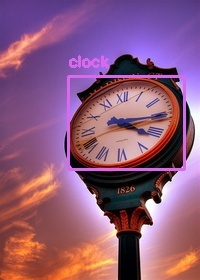

In [15]:
display_image_from_response(prediction)

다른 이미지에서 테스트해 봅니다.

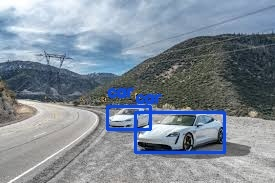

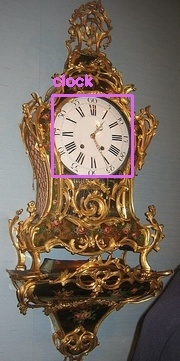

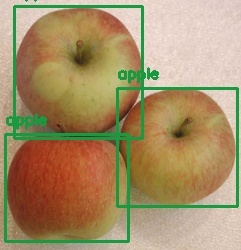

In [16]:
image_files = [
    'car2.jpg',
    'clock3.jpg',
    'apples.jpg'
]

for image_file in image_files:
    with open(f"images/{image_file}", "rb") as image_file:
        prediction = response_from_server(full_url, image_file, verbose=False)
    
    display_image_from_response(prediction)

위의 코드는 실제 프로덕션 환경에서 딥 러닝 모델을 배포하고 모델을 사용하는 프로세스와 비슷합니다.